IMPORTS

In [211]:
import pandas as pd
!pip install pm4py
import pm4py
!pip install openpyxl
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy.stats import chi2_contingency
from itertools import combinations


STEP 1

Unique Case IDs: 225
Unique Activities: 55
Unique Resources: 31
Unique Worker IDs: 49
Unique Part Descriptions: 43
Minimum StartTimestamp: 2012-01-02 00:00:00
Maximum CompleteTimestamp: 2012-03-31 05:45:00
Minimum Span: 0 days 00:00:00
Maximum Span: 0 days 23:50:00
Minimum WorkerOrderQuantity: 1
Maximum WorkerOrderQuantity: 720
Minimum QuantityCompleted: 0
Maximum QuantityCompleted: 473
Minimum QuantityRejected: 0
Maximum QuantityRejected: 28


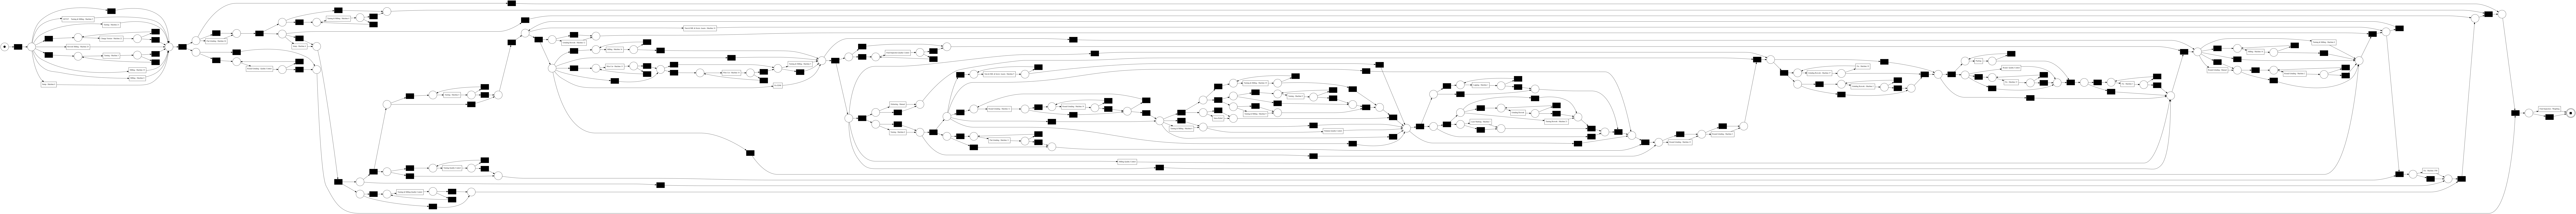

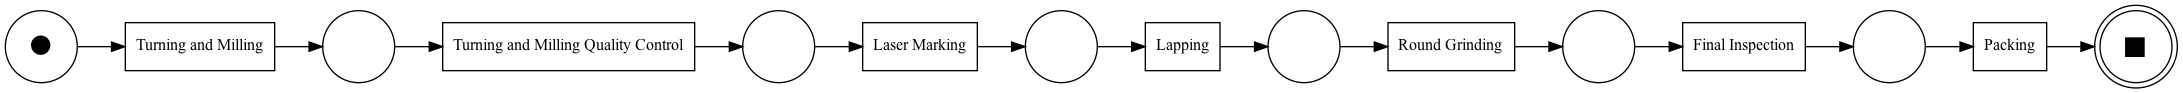

''

In [212]:
# STEP 1
df = pd.read_excel("Production_EventLog.xlsx", sheet_name="Original_DataSet")
df.head()

# convert StartTimestamp and CompleteTimestamp to datetime and calculate Span
df['StartTimestamp'] = pd.to_datetime(df['StartTimestamp'])
df['CompleteTimestamp'] = pd.to_datetime(df['CompleteTimestamp'])
df['Span'] = pd.to_datetime(df['CompleteTimestamp']) - pd.to_datetime(df['StartTimestamp'])

# Order by Case ID and StartTimestamp
df = df.sort_values(by=['Case ID', 'StartTimestamp']).reset_index(drop=True)

#count the unique number of case IDs, activities, resources, worker ID and part descriptions
print(f"Unique Case IDs: {df['Case ID'].nunique()}")
print(f"Unique Activities: {df['Activity'].nunique()}")
print(f"Unique Resources: {df['Resource'].nunique()}")
print(f"Unique Worker IDs: {df['Worker ID'].nunique()}")
print(f"Unique Part Descriptions: {df['PartDescription'].nunique()}")
#write the minimum of StartTimestamp and maximum of CompleteTimestamp
print(f"Minimum StartTimestamp: {df['StartTimestamp'].min()}")
print(f"Maximum CompleteTimestamp: {df['CompleteTimestamp'].max()}")
#write the minimum and maximum of Span
print(f"Minimum Span: {df['Span'].min()}")
print(f"Maximum Span: {df['Span'].max()}")
#Print the maximum and minimum of of WorkeOrderQuantity and of QuantityCompleted and QuantityRejected
print(f"Minimum WorkerOrderQuantity: {df['WorkOrderQuantity'].min()}")
print(f"Maximum WorkerOrderQuantity: {df['WorkOrderQuantity'].max()}")
print(f"Minimum QuantityCompleted: {df['QuantityCompleted'].min()}")
print(f"Maximum QuantityCompleted: {df['QuantityCompleted'].max()}")
print(f"Minimum QuantityRejected: {df['QuantityRejected'].min()}")
print(f"Maximum QuantityRejected: {df['QuantityRejected'].max()}")

# Rename columns to match PM4Py expectations
df = df.rename(columns={
    'Case ID': 'case:concept:name',
    'Activity': 'concept:name',
    'CompleteTimestamp': 'time:timestamp'
})

net, im, fm = pm4py.discover_petri_net_inductive(df)

# Visualize and save the Petri net
pm4py.view_petri_net(net, im, fm)
pm4py.save_vis_petri_net(net, im, fm, "petri_net_initial_AS_IS.png")

#Visualize the TO BE Petri net
net, im, fm = pm4py.read_pnml("Planned_Production_Process.pnml")
pm4py.view_petri_net(net, im, fm)
pm4py.save_vis_petri_net(net, im, fm, "petri_net_planned_TO_BE.png")



STEP 2

In [213]:
#Data cleaning

# Load the data
df = pd.read_excel("Production_EventLog.xlsx", sheet_name="Production_Eventlog2")

# Convert timestamps to datetime objects
df['StartTimestamp'] = pd.to_datetime(df['StartTimestamp'])
df['CompleteTimestamp'] = pd.to_datetime(df['CompleteTimestamp'])

# Calculate the duration (Span) for each activity
df['Span'] = df['CompleteTimestamp'] - df['StartTimestamp']

# Order by Case ID and StartTimestamp to ensure process flow is chronological
df = df.sort_values(by=['Case ID', 'StartTimestamp']).reset_index(drop=True)

#write the total number of rows
print(f"Total number of rows before cleaning: {len(df)}")
#print the toatl number of unique CASE IDs
print(f"Total number of unique Case IDs before cleaning: {df['Case ID'].nunique()}")

# Delete rows where no work was actually recorded (0 completed and 0 rejected)
#df = df[~((df['QuantityCompleted'] == 0) & (df['QuantityRejected'] == 0))]
#write the total number of rows after cleaning 0/0 activities
print(f"Total number of rows after removing 0/0 activities: {len(df)}")
#print the toatl number of unique CASE IDs
print(f"Total number of unique Case IDs after removing 0/0 activities: {df['Case ID'].nunique()}")

activities_to_skip = ['SETUP Turning & Milling'] 
    
# Filter the DataFrame to keep only activities NOT in the skip list
df = df[~df['Activity'].isin(activities_to_skip)]

# --- DATA AGGREGATION ---
# Identify groups of consecutive identical activities within the same Case ID
df['prev_activity'] = df.groupby('Case ID')['Activity'].shift(1)
df['new_group'] = (df['Activity'] != df['prev_activity']).astype(int)
df['group_id'] = df.groupby('Case ID')['new_group'].cumsum()

# Re-aggregate the data based on Case ID and group_id, summing durations and quantities, and taking the first occurrence of other attributes
agg_cols = {
    'Activity': 'first',
    'Resource': 'first', 
    'StartTimestamp': 'first',
    'CompleteTimestamp': 'last',
    'Span': 'sum',
    'WorkOrderQuantity': 'first',
    'PartDescription': 'first',
    'Worker ID': 'first',
    'QuantityCompleted': 'sum',
    'QuantityRejected': 'sum'
}

df_grouped = df.groupby(['Case ID', 'group_id'], as_index=False).agg(agg_cols)

#write the total number of rows after aggregation
print(f"Total number of rows after aggregation: {len(df_grouped)}")
#print the toatl number of unique CASE IDs
print(f"Total number of unique Case IDs after aggregation: {df_grouped['Case ID'].nunique()}")

# --- PM4Py FORMATTING ---
# Rename columns to the standard format PM4Py expects
df_grouped = df_grouped.rename(columns={
    'Case ID': 'case:concept:name',
    'Activity': 'concept:name',
    'CompleteTimestamp': 'time:timestamp'
})

# Clean up activity names for a cleaner Petri Net visualization
df_grouped['concept:name'] = df_grouped['concept:name'].replace({
    'Final Inspection Quality Control': 'Final Inspection',
    'Turning & Milling': 'Turning and Milling',
    'Turning & Milling Quality Control': 'Turning and Milling Quality Control'
})


Total number of rows before cleaning: 4543
Total number of unique Case IDs before cleaning: 225
Total number of rows after removing 0/0 activities: 4543
Total number of unique Case IDs after removing 0/0 activities: 225
Total number of rows after aggregation: 2450
Total number of unique Case IDs after aggregation: 225


In [214]:
# ANALYSIS OF FINISHED VS UNFINISHED CASES AND WITH LOOPS AND WITHOUT LOOPS---


# Sort the grouped dataframe by case ID and timestamp to ensure correct event order
df_grouped = df_grouped.sort_values(['case:concept:name', 'time:timestamp'])

#calculate the number of times unique attivities happened as last activities for each case
last_activities = (
    df_grouped
    .groupby('case:concept:name')['concept:name']
    .apply(lambda x: x.iloc[-1])
)
#print the count of unique last activities
print("Count of unique last activities:")
print(last_activities.value_counts())

# Extract the last one activity for each case
last_one = (
    df_grouped
    .groupby('case:concept:name')['concept:name']
    .apply(lambda x: list(x.tail(1)))
)

# Select only the cases that end with ['Final Inspection'] or ['Packing']
valid_cases = last_one[
    last_one.apply(lambda x: x == ['Packing'] or x == ['Final Inspection'])
].index

# Filter the dataframe to keep only the valid cases

df_finished = df_grouped[
    df_grouped['case:concept:name'].isin(valid_cases)
].copy()

df_unfinished = df_grouped[
    ~df_grouped['case:concept:name'].isin(valid_cases)
].copy()

# Export the finished and unfinished cases to separate CSV files
df_finished.to_csv('Production_EventLog_Finished.csv', index=False)
df_unfinished.to_csv('Production_EventLog_Unfinished.csv', index=False)

# Analyze loops by counting unique (case, activity) pairs
df_with_loops = df_finished.sort_values(['case:concept:name', 'StartTimestamp', 'time:timestamp']).copy()
df_with_loops.to_csv('Production_EventLog_Finished_Processed_WithLoops.csv', index=False)

# Re-aggregate the dataset without loops based on Case ID and activity , summing durations and quantities, and taking the first occurrence of other attributes
agg_cols = {
    'concept:name': 'first',
    'Resource': 'first', 
    'StartTimestamp': 'first',
    'time:timestamp': 'last',
    'Span': 'sum',
    'WorkOrderQuantity': 'first',
    'PartDescription': 'first',
    'Worker ID': 'first',
    'QuantityCompleted': 'sum',
    'QuantityRejected': 'sum'
}

before = len(df_with_loops)
df_no_loops = df_finished.groupby(['case:concept:name', 'concept:name'], as_index=False).agg(agg_cols)
df_no_loops = df_no_loops.sort_values(['case:concept:name', 'StartTimestamp'])
after = len(df_no_loops)

print(f"  - With loops events: {before}")
print(f"  - No-loops events:   {after}")
print(f"  - Removed repeats:   {before-after} ({(before-after)/before*100:.1f}%)")
df_no_loops.to_csv('Production_EventLog_Finished_Processed_NoLoops.csv', index=False)



Count of unique last activities:
concept:name
Final Inspection                       88
Packing                                73
Turning and Milling Quality Control    18
Turning and Milling                    16
Laser Marking                          13
Lapping                                 5
Round Grinding                          4
Round Grinding - Quality Control        4
Grinding Rework                         2
Final Inspection - Weighting            1
Turn & Mill. & Screw Assem              1
Name: count, dtype: int64
  - With loops events: 1976
  - No-loops events:   1046
  - Removed repeats:   930 (47.1%)


RESOURCE ANALYSIS

In [215]:
#Resource analysis

def get_detailed_resource_usage(dataframe):
    temp_df = dataframe.copy()
   
    # 2. Advanced Grouping
    # We group by Resource and Activity, then calculate:
    # - Total_Rows: Count of every single line in the log
    # - Case_Count: Count of unique Case IDs
    usage = temp_df.groupby(['Resource', 'concept:name']).agg(
        Total_Rows=('concept:name', 'count'),
        Number_of_Cases=('case:concept:name', 'nunique')
    ).reset_index()
    
    # 3. Calculate the Average (Intensity of work per case)
    usage['Avg_Events_per_Case'] = (usage['Total_Rows'] / usage['Number_of_Cases']).round(2)
    
    # 4. Filter and Sort
    usage = usage[usage['Total_Rows'] > 0]
    usage = usage.sort_values(by=['Resource', 'Total_Rows'], ascending=[True, False])
    
    return usage

# Apply to both datasets
resource_analysis_with_loops = get_detailed_resource_usage(df_with_loops)
resource_analysis_no_loops = get_detailed_resource_usage(df_no_loops)

# --- EXPORT ---
resource_analysis_with_loops.to_csv('Resource_Detailed_WITH_Loops.csv', index=False)
resource_analysis_no_loops.to_csv('Resource_Detailed_NO_Loops.csv', index=False)

In [216]:
# --- RESOURCE UTILIZATION RATE ---
# 1. Calculate the total timeframe of the log
log_start = df_with_loops['StartTimestamp'].min()
log_end = df_with_loops['time:timestamp'].max()
total_log_duration_hours = (log_end - log_start).total_seconds() / 3600

# 2. Calculate total "Active Time" per resource (sum of Spans)
# Using 'Span' column as it represents actual processing time
resource_util = df_with_loops.groupby('Resource').agg({
    'Span': 'sum'
}).reset_index()

# 3. Convert Span sum to hours and calculate percentage
resource_util['Active_Hours'] = resource_util['Span'].dt.total_seconds() / 3600
resource_util['Utilization_Rate (%)'] = (resource_util['Active_Hours'] / total_log_duration_hours) * 100

print("\n--- Resource Utilization Analysis ---")
print(resource_util[['Resource', 'Active_Hours', 'Utilization_Rate (%)']].sort_values(by='Utilization_Rate (%)', ascending=False).to_string(index=False))


--- Resource Utilization Analysis ---
                     Resource  Active_Hours  Utilization_Rate (%)
              Quality Check 1   1642.016667             77.347203
Machine 6 - Turning & Milling   1167.816667             55.010010
Machine 4 - Turning & Milling   1100.133333             51.821786
   Machine 3 - Round Grinding    837.983333             39.473209
   Machine 2 - Round Grinding    792.300000             37.321295
        Machine 10 - Grinding    791.633333             37.289892
Machine 5 - Turning & Milling    760.950000             35.844553
Machine 9 - Turning & Milling    712.633333             33.568597
Machine 8 - Turning & Milling    609.633333             28.716781
          Machine 1 - Lapping    550.983333             25.954073
        Machine 27 - Grinding    470.016667             22.140137
                      Packing    238.000000             11.210991
        Machine 12 - Grinding    196.900000              9.274975
     Machine 7- Laser Marking    191.

THROUGHOUT ANALYSIS

In [217]:
def analyze_throughput(df, label):
    # Calculate throughput per Case ID
    # throughput = max(CompleteTimestamp) - min(StartTimestamp) 
    case_stats = df.groupby('case:concept:name').agg(
        Start=('StartTimestamp', 'min'),
        End=('time:timestamp', 'max'),
        Events=('concept:name', 'count'),
        Rejects=('QuantityRejected', 'sum')
    )
    case_stats['Throughput_Days'] = (case_stats['End'] - case_stats['Start']).dt.total_seconds() / (24 * 3600)
    
    mean_tp = case_stats['Throughput_Days'].mean()
    max_tp = case_stats['Throughput_Days'].max()
    min_tp = case_stats['Throughput_Days'].min()

    print(f"--- Throughput Analysis: {label} ---")
    print(f"Min Throughput: {min_tp:.2f} days")
    print(f"Mean Throughput: {mean_tp:.2f} days")
    print(f"Max Throughput: {max_tp:.2f} days")
    
    # Correlation Analysis for finished cases 
    correlation_events = case_stats['Throughput_Days'].corr(case_stats['Events'])
    correlation_rejects = case_stats['Throughput_Days'].corr(case_stats['Rejects'])
    print(f"Correlation (Duration vs Events): {correlation_events:.3f}")
    print(f"Correlation (Duration vs Rejects): {correlation_rejects:.3f}")
    
    # Quality Impact 
    with_rejects = case_stats[case_stats['Rejects'] > 0]['Throughput_Days'].mean()
    no_rejects = case_stats[case_stats['Rejects'] == 0]['Throughput_Days'].mean()
    print(f"Avg Throughput with Rejects: {with_rejects:.2f} days")
    print(f"Avg Throughput without Rejects: {no_rejects:.2f} days\n")

# Apply to your different log versions
analyze_throughput(df_with_loops, "With-Loops (As-Is)")
analyze_throughput(df_no_loops, "No-Loops (Refined)")
#analyze_throughput(df_unfinished, "Unfinished Cases")
analyze_throughput(df_grouped, "All Cases (Grouped)")

--- Throughput Analysis: With-Loops (As-Is) ---
Min Throughput: 0.04 days
Mean Throughput: 21.54 days
Max Throughput: 87.45 days
Correlation (Duration vs Events): 0.568
Correlation (Duration vs Rejects): 0.490
Avg Throughput with Rejects: 28.13 days
Avg Throughput without Rejects: 12.74 days

--- Throughput Analysis: No-Loops (Refined) ---
Min Throughput: 0.04 days
Mean Throughput: 21.54 days
Max Throughput: 87.45 days
Correlation (Duration vs Events): 0.406
Correlation (Duration vs Rejects): 0.490
Avg Throughput with Rejects: 28.13 days
Avg Throughput without Rejects: 12.74 days

--- Throughput Analysis: All Cases (Grouped) ---
Min Throughput: 0.02 days
Mean Throughput: 20.62 days
Max Throughput: 87.45 days
Correlation (Duration vs Events): 0.588
Correlation (Duration vs Rejects): 0.513
Avg Throughput with Rejects: 28.08 days
Avg Throughput without Rejects: 11.78 days



In [218]:
# --- THROUGHPUT EFFICIENCY BY PART DESCRIPTION ---
# Calculating duration per case first
case_durations = df_with_loops.groupby(['case:concept:name', 'PartDescription']).agg({
    'StartTimestamp': 'min',
    'time:timestamp': 'max',
    'QuantityRejected': 'sum'
}).reset_index()

case_durations['Total_Duration_Days'] = (
    case_durations['time:timestamp'] - case_durations['StartTimestamp']
).dt.total_seconds() / (24 * 3600)

# Aggregating by Part Type
part_efficiency = case_durations.groupby('PartDescription').agg({
    'Total_Duration_Days': ['mean', 'max', 'std'],
    'QuantityRejected': 'mean'
}).reset_index()

# Flattening columns for readability
part_efficiency.columns = ['PartDescription', 'Avg_Duration', 'Max_Duration', 'Std_Dev', 'Avg_Rejects']

print("--- Throughput Efficiency by Part Description ---")
print(part_efficiency.sort_values(by='Avg_Duration', ascending=False).to_string(index=False))

--- Throughput Efficiency by Part Description ---
   PartDescription  Avg_Duration  Max_Duration   Std_Dev  Avg_Rejects
              Shim     57.816667     57.816667       NaN     2.000000
      Punch Holder     50.700926     84.531944 29.391123    15.000000
             Clamp     40.337847     73.627778 47.079071     3.500000
       Punch Plate     39.214236     40.731250  2.145382     5.000000
              Plug     37.240139     42.321528  7.915477     2.000000
           Adapter     37.115972     37.115972       NaN     3.000000
       Flange Bolt     36.943750     36.943750       NaN     2.000000
        Cable Head     36.933616     87.454861 25.815106     5.037037
           Spinner     35.693750     35.693750       NaN     6.000000
Electrical Contact     33.286806     46.000000 17.979172     7.500000
             Drill     31.444676     71.583333 34.971784     2.000000
            Socket     27.615278     27.615278       NaN     2.000000
     Cutting Wheel     25.415278     25.

QUALITY ANALYSIS

In [219]:
def quality_analysis(df, label):
    print(f"\n{'='*25} QUALITY ANALYSIS: {label.upper()} {'='*25}")
    
    # --- GLOBAL METRICS (Overall Portfolio) ---
    # Total quantity ordered across all unique cases in this dataframe
    total_ordered = df.groupby('case:concept:name')['WorkOrderQuantity'].first().sum()
    # Total quantity rejected across all events
    total_rejected_global = df['QuantityRejected'].sum()
    
    global_reject_pct = (total_rejected_global / total_ordered * 100) if total_ordered > 0 else 0
    
    print(f"Total WorkOrderQuantity (Sum of unique orders): {total_ordered}")
    print(f"Total Rejects (Sum of all failures): {total_rejected_global}")
    print(f"Overall Process Reject Rate: {global_reject_pct:.2f}%")
    print("-" * 50)

    # --- ACTIVITY-LEVEL BREAKDOWN ---
    # 1. Grouping and Aggregating Rejects per activity
    quality_df = df.groupby('concept:name').agg({
        'QuantityRejected': 'sum',
        'QuantityCompleted': 'sum'
    }).reset_index()
    
    # 2. Calculating Yield Metrics per activity
    quality_df['Total_Processed'] = quality_df['QuantityRejected'] + quality_df['QuantityCompleted']
    quality_df['Percentage_Rejects (%)'] = (quality_df['QuantityRejected'] / quality_df['Total_Processed']) * 100
    
    # 3. Filtering: Only activities with more than 0 rejected 
    problematic_activities = quality_df[quality_df['QuantityRejected'] > 0].copy()
    
    # 4. Formatting and Sorting
    problematic_activities = problematic_activities.rename(columns={
        'concept:name': 'Activity',
        'QuantityRejected': 'Number of Rejects'
    })
    
    result_table = problematic_activities[['Activity', 'Number of Rejects', 'Percentage_Rejects (%)']].sort_values(
        by='Number of Rejects', ascending=False
    )
    
    if result_table.empty:
        print("No activities with rejects found in this dataset.")
    else:
        print(result_table.to_string(index=False, float_format=lambda x: "{:.2f}".format(x)))
    print(f"{'='*75}\n")

# --- EXECUTION BLOCKS ---
quality_analysis(df_finished, "Finished Cases")
quality_analysis(df_unfinished, "Unfinished Cases")


========================= QUALITY ANALYSIS: FINISHED CASES =========================
Total WorkOrderQuantity (Sum of unique orders): 13920
Total Rejects (Sum of all failures): 418
Overall Process Reject Rate: 3.00%
--------------------------------------------------
                           Activity  Number of Rejects  Percentage_Rejects (%)
                   Final Inspection                181                    1.71
Turning and Milling Quality Control                168                    1.58
   Round Grinding - Quality Control                 26                    3.10
                     Round Grinding                 21                    0.28
                      Laser Marking                  9                    0.09
                Turning and Milling                  9                    0.08
                      Flat Grinding                  2                    0.07
             Round  Quality Control                  2                    6.45


====================

In [220]:
# Export the final grouped dataframe to an Excel file
df_grouped.to_excel("df_grouped_3.xlsx", index=False)


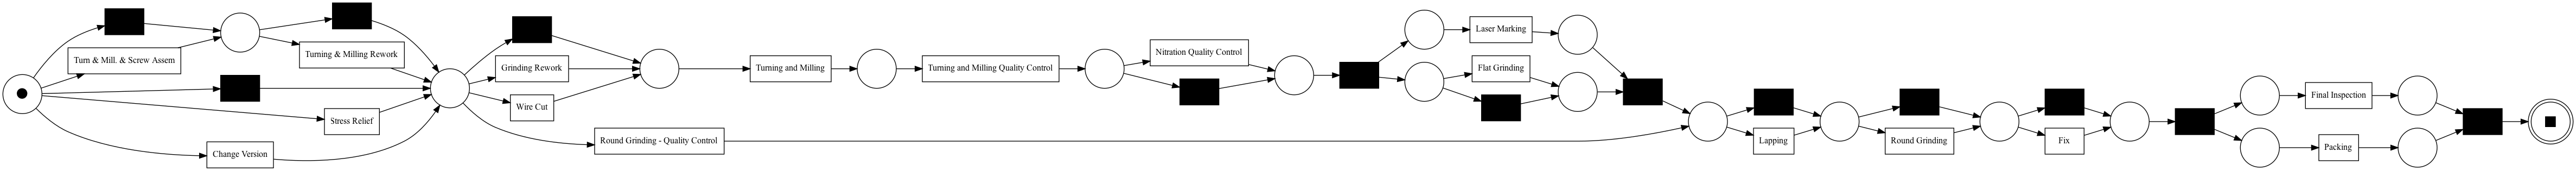

''

In [221]:
# --- PROCESS MINING ---
# Discover the Petri net for df_no_loops using the Inductive Miner with a noise threshold to filter out infrequent behavior
net, im, fm = pm4py.discover_petri_net_inductive(df_no_loops, noise_threshold=0.2)
pm4py.view_petri_net(net, im, fm)

# Save the Petri net as an image file
pm4py.save_vis_petri_net(net, im, fm, "petri_net_inductive_no_loops.png")

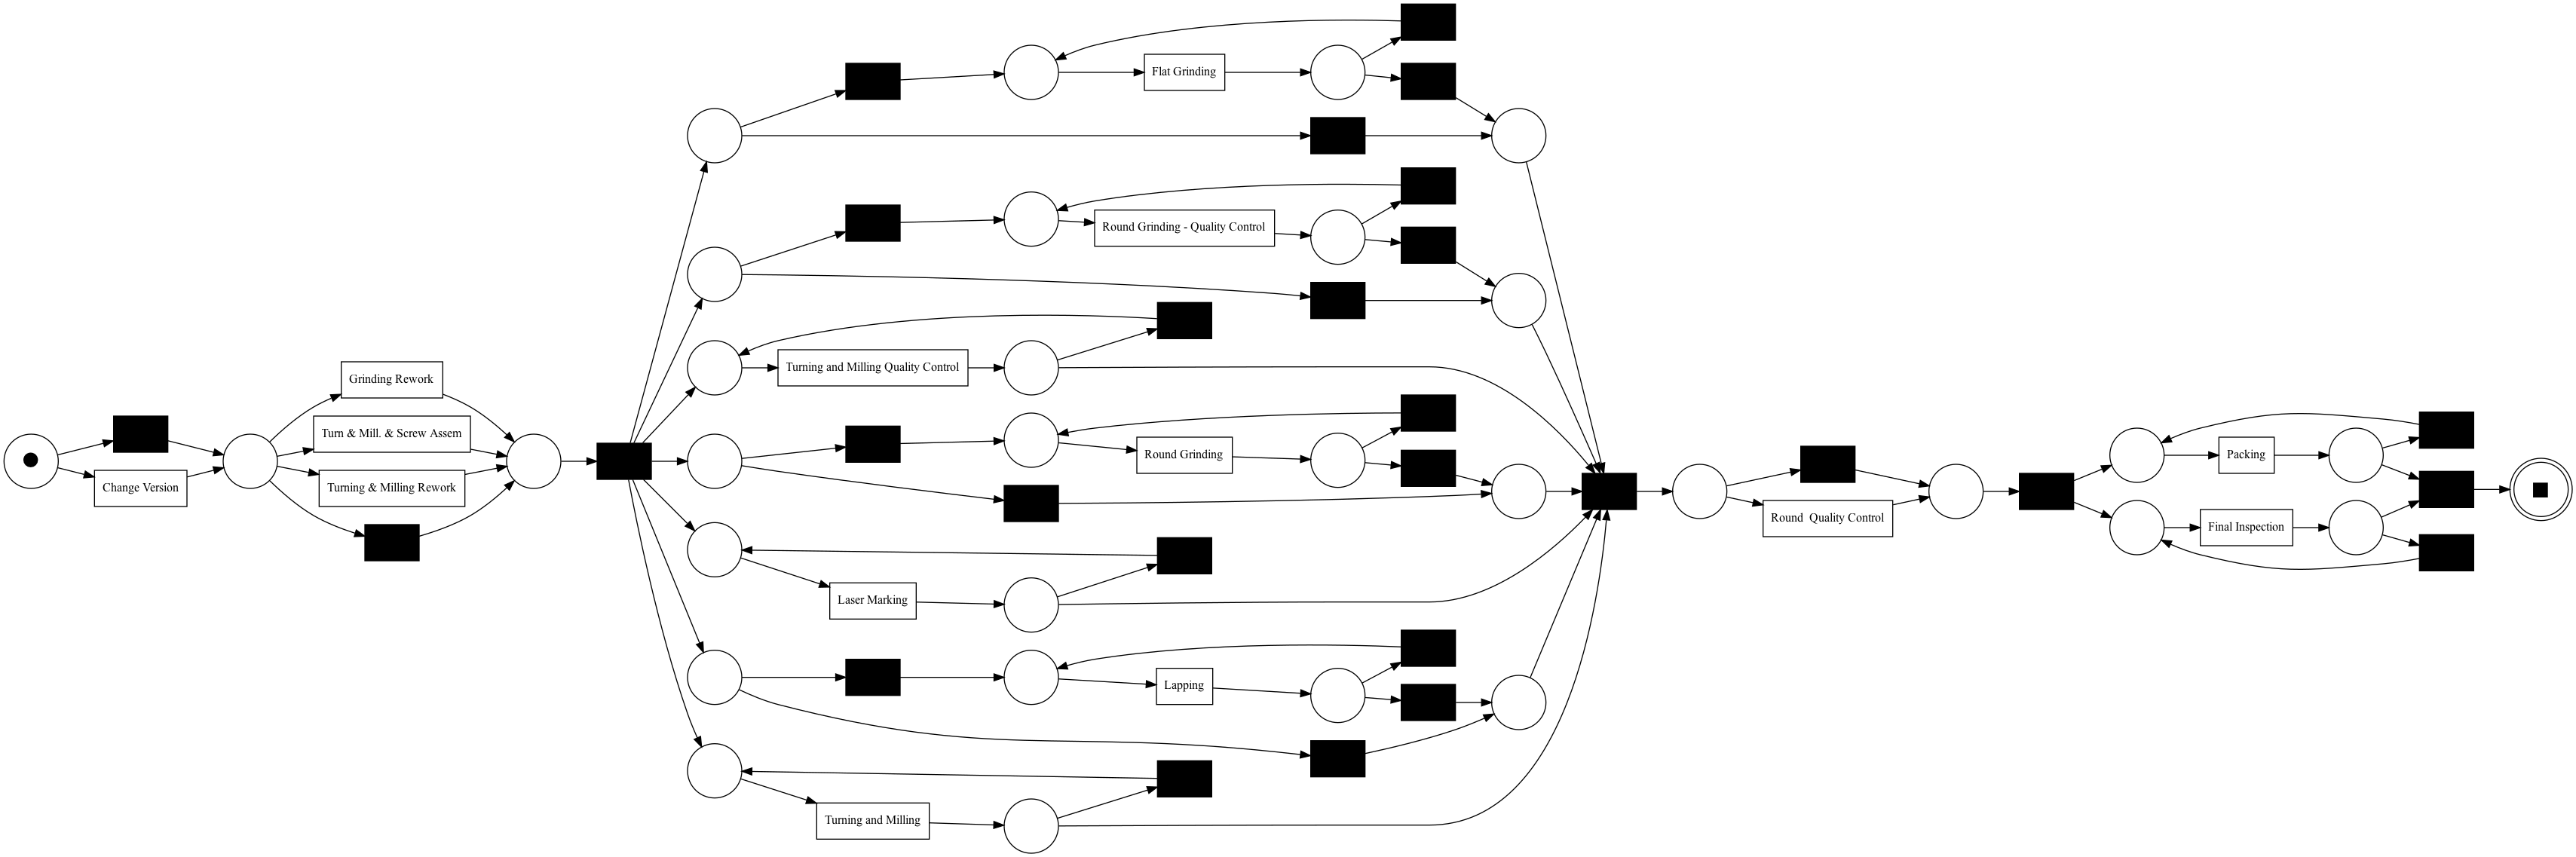

''

In [222]:
# Discover the Petri net for df_with_loops using the Inductive Miner with a noise threshold to filter out infrequent behavior
net, im, fm = pm4py.discover_petri_net_inductive(df_with_loops, noise_threshold=0.2)
pm4py.view_petri_net(net, im, fm)

# Save the Petri net as an image file
pm4py.save_vis_petri_net(net, im, fm, "petri_net_inductive_with_loops.png")

STEP 3: CONFORMANCE CHECKING

In [223]:
# --- CONFORMANCE CHECKING ---

log = df_with_loops
net, initial_marking, final_marking = pnml_importer.apply("Planned_production_Process.pnml")

aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking)

# Count non-conforming traces for the log with loops
non_conforming = sum(1 for trace in aligned_traces if trace['fitness'] < 1)
total_traces = len(aligned_traces)
print(f"For log with loops:")
print(f"Total traces: {total_traces}")
print("Non-conforming traces:", non_conforming)
print("Percentage:", non_conforming / total_traces)

log = df_no_loops

aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking)

# Count non-conforming traces for the log without loops
non_conforming = sum(1 for trace in aligned_traces if trace['fitness'] < 1)
total_traces = len(aligned_traces)
print(f"For log without loops:")
print(f"Total traces: {total_traces}")
print("Non-conforming traces:", non_conforming)
print("Percentage:", non_conforming / total_traces)

aligning log, completed variants :: 100%|██████████| 148/148 [00:00<00:00, 504.64it/s]


For log with loops:
Total traces: 161
Non-conforming traces: 160
Percentage: 0.9937888198757764


aligning log, completed variants :: 100%|██████████| 107/107 [00:00<00:00, 813.75it/s]

For log without loops:
Total traces: 161
Non-conforming traces: 149
Percentage: 0.9254658385093167


In [224]:
# Allignment-based fitness calculation

log = df_with_loops
fitness = replay_fitness.apply(log, net, initial_marking, final_marking,

                               variant=replay_fitness.Variants.ALIGNMENT_BASED)
print(f"For log with loops:")
print(fitness)

log = df_no_loops
fitness = replay_fitness.apply(log, net, initial_marking, final_marking,

                               variant=replay_fitness.Variants.ALIGNMENT_BASED)
print(f"For log without loops:")
print(fitness)

 

aligning log, completed variants :: 100%|██████████| 148/148 [00:00<00:00, 486.98it/s]


For log with loops:
{'percFitTraces': 0.6211180124223602, 'averageFitness': 0.6170057697433109, 'percentage_of_fitting_traces': 0.6211180124223602, 'average_trace_fitness': 0.6170057697433109, 'log_fitness': 0.558814050918466}


aligning log, completed variants :: 100%|██████████| 107/107 [00:00<00:00, 789.53it/s]

For log without loops:
{'percFitTraces': 7.453416149068323, 'averageFitness': 0.7507733710693155, 'percentage_of_fitting_traces': 7.453416149068323, 'average_trace_fitness': 0.7507733710693155, 'log_fitness': 0.7657616198803497}


In [225]:
# Reason behind the non-conformance and fitness results

#counting the activities in the log that do not appear in the to-be model and how many times they appear in the log

to_be_activities = [
    "Turning and Milling",
    "Turning and Milling Quality Control",
    "Laser Marking",
    "Lapping",
    "Round Grinding",
    "Final Inspection",
    "Packing"
]

# Select activities that do NOT appear in the To-Be model
non_conforming_activities = df_finished[
    ~df_finished["concept:name"].isin(to_be_activities)
]

# Count how many times each non-conforming activity appears
activity_counts = (
    non_conforming_activities["concept:name"]
    .value_counts()
)

# Print results
print("Activities not included in the To-Be model and their frequencies:")
print(activity_counts)

# Count the unique traces in the log that contain at least one non-conforming activity
non_conforming_cases = non_conforming_activities["case:concept:name"].nunique()
total_cases = df_finished["case:concept:name"].nunique()
print(f"Number of cases with at least one non-conforming activity: {non_conforming_cases}")
print(f"Total number of cases: {total_cases}")

# calculate the numbers of cases that does NOT contain all the activities from the to_be_activities list
cases_with_all_to_be_activities = df_finished.groupby("case:concept:name")["concept:name"].apply(
    lambda activities: all(activity in activities.values for activity in to_be_activities)
).sum()
cases_without_all_to_be_activities = total_cases - cases_with_all_to_be_activities
print(f"Number of cases that contain all To-Be activities: {cases_with_all_to_be_activities}")
print(f"Number of cases that do NOT contain all To-Be activities: {cases_without_all_to_be_activities}")

#count the unique numbers of traces that OR contain at least one non-conforming activity OR do not contain all the activities from the to-be model, don't count them twice
cases_with_non_conformance = df_finished.groupby("case:concept:name")["concept:name"].apply(
    lambda activities: any(activity not in to_be_activities for activity in activities.values) or
                       not all(activity in activities.values for activity in to_be_activities)
).sum()
print(f"Number of cases with non-conformance (either at least one non-conforming activity or missing some To-Be activities): {cases_with_non_conformance}")

# tell me the cases that remaing after filtering out the cases with non-conformance and the conformance one
conforming_cases = df_finished.groupby("case:concept:name")["concept:name"].apply(
    lambda activities: not any(activity not in to_be_activities for activity in activities.values) and
                       all(activity in activities.values for activity in to_be_activities)
).index[df_finished.groupby("case:concept:name")["concept:name"].apply(
    lambda activities: not any(activity not in to_be_activities for activity in activities.values) and
                       all(activity in activities.values for activity in to_be_activities)
)].tolist()
print(f"Conforming cases: {conforming_cases}")



Activities not included in the To-Be model and their frequencies:
concept:name
Flat Grinding                       77
Grinding Rework                     38
Round Grinding - Quality Control    34
Turn & Mill. & Screw Assem           9
Deburring                            8
Wire Cut                             7
Nitration Quality Control            4
Round  Quality Control               2
Turning & Milling Rework             2
Stress Relief                        2
Fix                                  2
Change Version                       1
Name: count, dtype: int64
Number of cases with at least one non-conforming activity: 94
Total number of cases: 161
Number of cases that contain all To-Be activities: 65
Number of cases that do NOT contain all To-Be activities: 96
Number of cases with non-conformance (either at least one non-conforming activity or missing some To-Be activities): 141
Conforming cases: ['Case 1', 'Case 126', 'Case 174', 'Case 207', 'Case 22', 'Case 232', 'Case 242', 'C

In [226]:
def run_quality_chi2_test(df, column_name):
    print(f"\n--- Statistical Quality Test: {column_name} ---")
    
    # 1. Create a binary 'Is_Rejected' flag
    df_test = df.copy()
    df_test['Is_Rejected'] = df_test['QuantityRejected'] > 0
    
    # 2. Create a Contingency Table (Cross-tabulation)
    contingency_table = pd.crosstab(df_test[column_name], df_test['Is_Rejected'])
    
    # 3. Perform Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Statistic: {chi2:.2f}")
    print(f"P-Value: {p:.4f}")
    
    if p < 0.05:
        print(f"RESULT: Significant difference found! Quality depends on the {column_name}.")
    else:
        print(f"RESULT: No significant difference. Quality is uniform across {column_name}s.")
    
    return p

# Run for Machines
run_quality_chi2_test(df_no_loops, 'Resource')

# Run for Parts
run_quality_chi2_test(df_no_loops, 'PartDescription')


--- Statistical Quality Test: Resource ---
Chi-Square Statistic: 252.58
P-Value: 0.0000
RESULT: Significant difference found! Quality depends on the Resource.

--- Statistical Quality Test: PartDescription ---
Chi-Square Statistic: 44.06
P-Value: 0.1675
RESULT: No significant difference. Quality is uniform across PartDescriptions.


np.float64(0.16751559903210875)

STEP 5: PREDICTION MODEL FOR REMAINING TIME

In [228]:
# --- A. PREFIX PRE-PROCESSING ---
def generate_prefixes(df, case_id_col, time_col):
    prefixes = []
    # Sort to ensure chronological order for prefixing 
    df = df.sort_values([case_id_col, time_col])
    
    # Track metrics for reporting 
    case_groups = df.groupby(case_id_col)
    total_cases = len(case_groups)
    
    for cid, group in case_groups:
        case_end_time = group[time_col].max()
        
        # We generate a prefix for every step in the process (L events = L prefixes) 
        for i in range(1, len(group) + 1):
            prefix = group.iloc[:i].copy()
            current_event_time = prefix[time_col].iloc[-1]
            
            # Target: Remaining Time (0 if it's the final event)
            remaining_time = (case_end_time - current_event_time).total_seconds() / 3600
            
            feature_dict = {
                'Case ID': cid,
                'Prefix_Length': i,
                'Last_Activity': prefix['concept:name'].iloc[-1],
                'Last_Resource': prefix['Resource'].iloc[-1],
                'WorkOrderQuantity': prefix['WorkOrderQuantity'].iloc[0],
                'Elapsed_Time': (current_event_time - group[time_col].iloc[0]).total_seconds() / 3600,
                'Cumulative_Rejects': prefix['QuantityRejected'].sum()
            }
            feature_dict['Target_Remaining_Time'] = remaining_time
            prefixes.append(feature_dict)
            
    prefix_df = pd.DataFrame(prefixes)
    
    # Printing the requested metrics for Step 5 justification 
    print(f"--- Prefix Generation Summary ---")
    print(f"Total Cases Processed: {total_cases}")
    print(f"Total Prefixes Generated: {len(prefix_df)}")
    print(f"Average Prefixes per Case: {len(prefix_df)/total_cases:.2f}")
    print(f"---------------------------------")
    
    return prefix_df

def run_tiered_experiment(df, label):
    print(f"\n{'='*20} DATASET: {label.upper()} {'='*20}")
    
    # 1. Prefix Generation & Description 
    df_prefix = generate_prefixes(df, 'case:concept:name', 'time:timestamp')
    
    # Define Feature Tiers for Iterative Testing 
    feature_sets = {
        "Tier 1 (Time+Act)": ['Elapsed_Time', 'Last_Activity'],
        "Tier 2 (+Resource)": ['Elapsed_Time', 'Last_Activity', 'Last_Resource'],
        "Tier 3 (Full Context)": ['Elapsed_Time', 'Last_Activity', 'Last_Resource', 
                                  'WorkOrderQuantity', 'Prefix_Length', 'Cumulative_Rejects']
    }
    
    # Temporal Train-Test Split (70/30)
    unique_cases = df_prefix['Case ID'].unique()
    train_ids, test_ids = train_test_split(unique_cases, test_size=0.3, random_state=42)
    train_df = df_prefix[df_prefix['Case ID'].isin(train_ids)]
    test_df = df_prefix[df_prefix['Case ID'].isin(test_ids)]
    
    tier_results = []

    for tier_name, base_features in feature_sets.items():
        # One-Hot Encoding for categorical data 
        cat_cols = [c for c in ['Last_Activity', 'Last_Resource'] if c in base_features]
        X_train = pd.get_dummies(train_df[base_features], columns=cat_cols)
        X_test = pd.get_dummies(test_df[base_features], columns=cat_cols)
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
        
        y_train = train_df['Target_Remaining_Time']
        y_test = test_df['Target_Remaining_Time']
        
        # Testing Algorithms 
        models = {
            "Decision Tree": DecisionTreeRegressor(random_state=42),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
        }
        
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
            mae = mean_absolute_error(y_test, preds)
            rmse = root_mean_squared_error(y_test, preds)
            
            tier_results.append({
                "Feature Tier": tier_name,
                "Algorithm": model_name,
                "MAE (h)": round(mae, 2),
                "RMSE (h)": round(rmse, 2)
            })
    
    # Display the results table for this specific block 
    results_df = pd.DataFrame(tier_results)
    pivot_table = results_df.pivot_table(index="Feature Tier", columns="Algorithm", values=["MAE (h)", "RMSE (h)"])
    
    print(f"\n--- Performance Grid for {label} ---")
    display(pivot_table)
    print(f"{'='*55}\n")

# --- B. EXECUTION BLOCKS ---

# Block 1: With Loops 
run_tiered_experiment(df_with_loops, "With Loops")

# Block 2: Without Loops 
run_tiered_experiment(df_no_loops, "Without Loops")

# Block 1: With Loops 
run_tiered_experiment(df_grouped, "All Cases")


==================== DATASET: WITH LOOPS ====================
--- Prefix Generation Summary ---
Total Cases Processed: 161
Total Prefixes Generated: 1976
Average Prefixes per Case: 12.27
---------------------------------

--- Performance Grid for With Loops ---


MAE (h)                    RMSE (h)              
Algorithm             Decision Tree Random Forest Decision Tree Random Forest
Feature Tier                                                                 
Tier 1 (Time+Act)            382.89        329.15        578.63        461.01
Tier 2 (+Resource)           367.70        315.48        563.23        448.01
Tier 3 (Full Context)        392.47        343.74        579.39        458.17



==================== DATASET: WITHOUT LOOPS ====================
--- Prefix Generation Summary ---
Total Cases Processed: 161
Total Prefixes Generated: 1046
Average Prefixes per Case: 6.50
---------------------------------

--- Performance Grid for Without Loops ---


MAE (h)                    RMSE (h)              
Algorithm             Decision Tree Random Forest Decision Tree Random Forest
Feature Tier                                                                 
Tier 1 (Time+Act)            185.46        172.93        347.72        290.79
Tier 2 (+Resource)           178.18        164.62        335.31        282.44
Tier 3 (Full Context)        179.65        161.74        358.58        265.26



==================== DATASET: ALL CASES ====================
--- Prefix Generation Summary ---
Total Cases Processed: 225
Total Prefixes Generated: 2450
Average Prefixes per Case: 10.89
---------------------------------

--- Performance Grid for All Cases ---


MAE (h)                    RMSE (h)              
Algorithm             Decision Tree Random Forest Decision Tree Random Forest
Feature Tier                                                                 
Tier 1 (Time+Act)            413.00        352.54        612.85        501.13
Tier 2 (+Resource)           416.52        358.85        614.61        513.10
Tier 3 (Full Context)        374.56        309.85        543.28        450.65